# Titanic

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

## Access Data

In [2]:
data = r'https://github.com/pestyld/data/raw/main/titanic_train.zip'
df_raw = pd.read_csv(data, compression = 'zip')
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Explore data

In [3]:
df_raw.shape

(891, 12)

In [4]:
df_raw.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Missing values

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

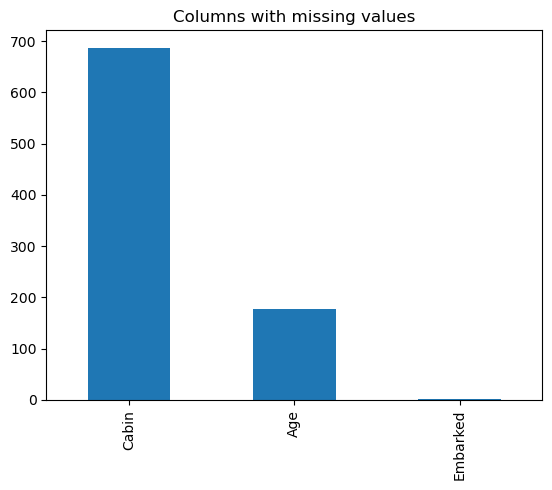

In [5]:
missing_values = (df_raw
                  .isna()
                  .sum()
                  .sort_values(ascending = False)
                )

display(missing_values)

(missing_values
 .loc[missing_values > 0]
 .plot(kind = 'bar', title = 'Columns with missing values')
);

<Axes: >

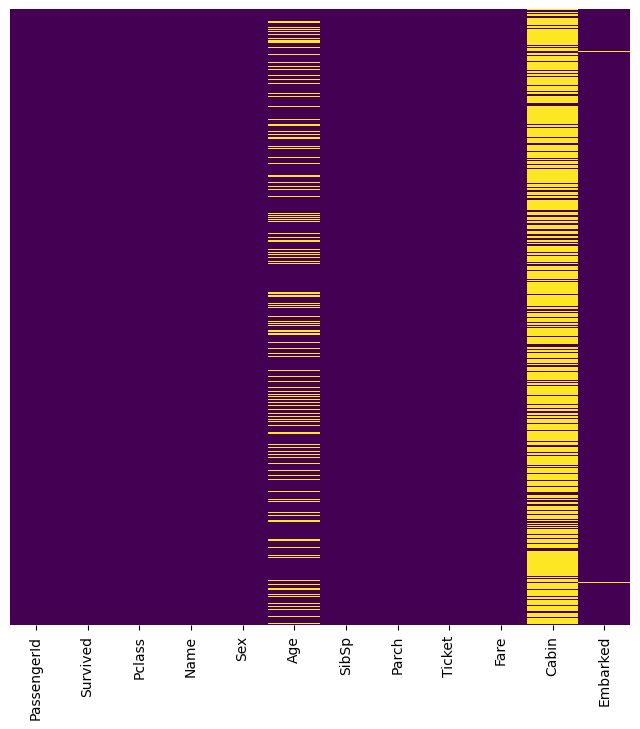

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(df_raw.isnull(), yticklabels=False, cbar = False, cmap='viridis', ax = ax )

### Explore columns

### Target

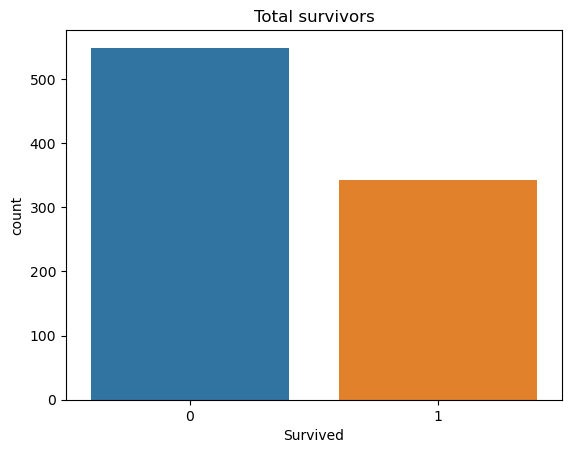

In [7]:
sns.countplot(data=df_raw, x = 'Survived')
plt.title('Total survivors');

### Categorical

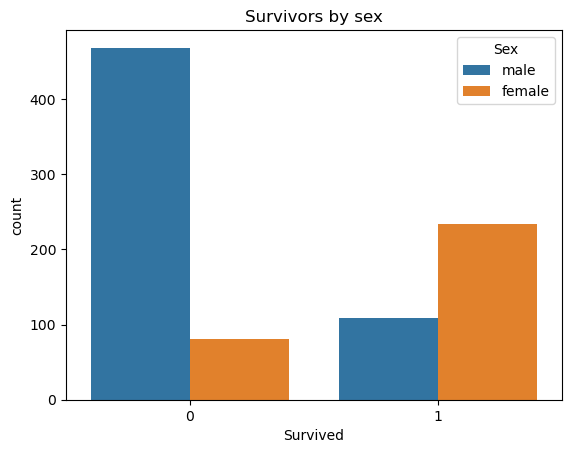

In [8]:
sns.countplot(x ='Survived', hue='Sex', data=df_raw)
plt.title('Survivors by sex');

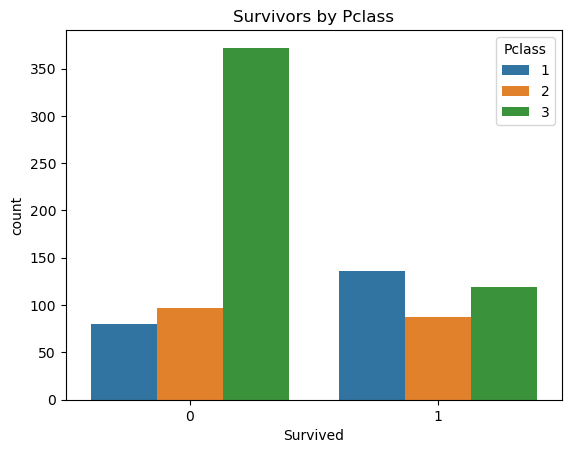

In [23]:
sns.countplot(x ='Survived', hue='Pclass', data=df_raw)
plt.title('Survivors by Pclass');

<Axes: xlabel='Pclass', ylabel='Age'>

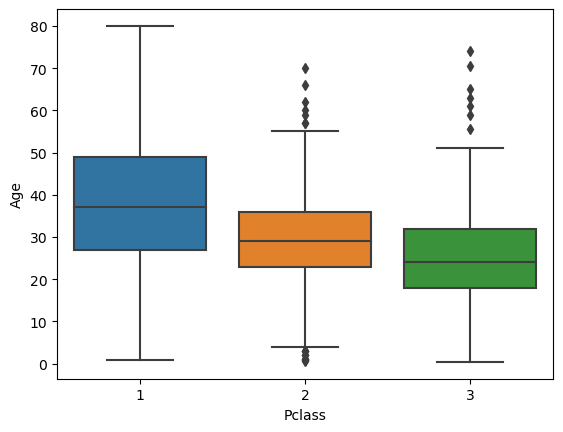

In [10]:
sns.boxplot(data = df_raw, x = 'Pclass', y = 'Age')

<Axes: xlabel='SibSp', ylabel='count'>

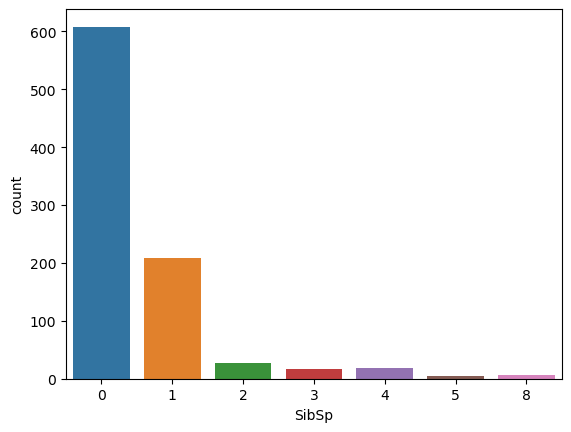

In [11]:
sns.countplot(x = 'SibSp', data = df_raw)

### Numeric

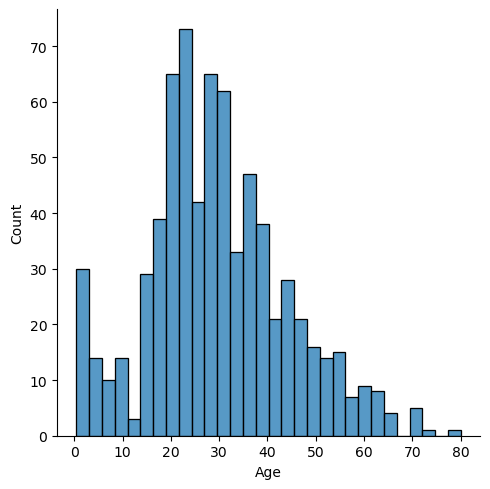

In [12]:
sns.displot(df_raw['Age'].dropna(), kde = False, bins=30)

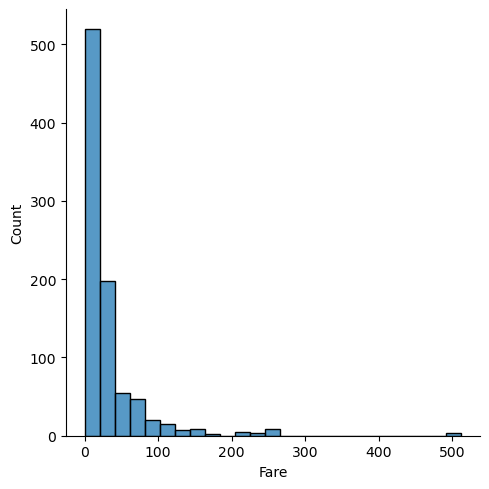

In [13]:
sns.displot(df_raw['Fare'], kde = False, bins=25)

In [14]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Prepare data

### Test dummy variale code

In [24]:
pd.get_dummies(df_raw['Sex'], drop_first = True)

,male
0,1
1,0
2,0
3,0
4,1
...,...
886,1
887,0
888,0
889,1


### Test some code to find the mean of each group and replace missing values by class.

In [25]:
df_raw.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [27]:
meanAgeByClass = df_raw.loc[:,['Pclass','Age']].groupby('Pclass').mean().round()
display(meanAgeByClass)

def impute_missing_age(df, col):
    meanAgeByClass = (df_raw
                      .loc[:,['Pclass','Age']]
                      .groupby('Pclass')
                      .mean()
                      .round()
                     )

    imputed_age = np.select([ ## Conditionas
                             df.loc[:,'Pclass'] == 1, 
                             df.loc[:,'Pclass'] == 2, 
                             df.loc[:,'Pclass'] == 3],
                            [ ## choice list
                             df[col].fillna(meanAgeByClass.loc[1][0]), 
                             df[col].fillna(meanAgeByClass.loc[2][0]), 
                             df[col].fillna(meanAgeByClass.loc[3][0])
                            ])
    
    return imputed_age


(df_raw
 .assign(impute_test = impute_missing_age(df_raw,'Age'))
)

,Age
Pclass,
1,38.0
2,30.0
3,25.0


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,impute_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,27.0
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,19.0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,25.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,26.0


In [18]:
df_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Final code

In [29]:
##
## Impute missing values in the age column
##
def impute_missing_age(df, col):
    ''' Replace missing values of age by Pclass'''
    
    ## Get the mean value by each Pclass
    meanAgeByClass = (df_raw
                      .loc[:,['Pclass','Age']]
                      .groupby('Pclass')
                      .mean()
                      .round()
                     )

    ## Impute missing values
    imputed_age = np.select([ ## Conditionas
                             df.loc[:,'Pclass'] == 1, 
                             df.loc[:,'Pclass'] == 2, 
                             df.loc[:,'Pclass'] == 3],
                            [ ## choice list
                             df['Age'].fillna(meanAgeByClass.loc[1][0]), 
                             df['Age'].fillna(meanAgeByClass.loc[2][0]), 
                             df['Age'].fillna(meanAgeByClass.loc[3][0])
                            ])
    
    return imputed_age


##
## Impute missing values in the embarked column
##
def impute_missing_embarked():
    return df_raw.Embarked.mode()[0]
mode_fill_value = impute_missing_embarked()


##
## Drop columns
##
dropColumns = ['Name', 'Ticket', 'Cabin', 'PassengerId']


##
## Prepare data
##
df = (
    df_raw
    .assign(
        Age_IMP = impute_missing_age(df_raw, 'Age'),
        Embarked_IMP = df_raw.Embarked.fillna(mode_fill_value) 
           )
    .drop(dropColumns, axis = 1)
)


##
## Convert categorical variable into dummy/indicator variables.
##

dummy_cols_sex = pd.get_dummies(df['Sex'], drop_first = True)
dummy_cols_embarked = pd.get_dummies(df['Embarked'], drop_first = True)
dummy_cols_pclass = pd.get_dummies(df['Pclass'], drop_first = True)
df = pd.concat([df, dummy_cols_sex, dummy_cols_embarked, dummy_cols_pclass], axis = 1)


## Validation
display(df.head(), 
        df.isna().sum()
       )

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_IMP,Embarked_IMP,male,Q,S,2,3
0,0,3,male,22.0,1,0,7.2500,S,22.0,S,1,0,1,0,1
1,1,1,female,38.0,1,0,71.2833,C,38.0,C,0,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,S,26.0,S,0,0,1,0,1
3,1,1,female,35.0,1,0,53.1000,S,35.0,S,0,0,1,0,0
4,0,3,male,35.0,0,0,8.0500,S,35.0,S,1,0,1,0,1


Survived          0
Pclass            0
Sex               0
Age             177
SibSp             0
Parch             0
Fare              0
Embarked          2
Age_IMP           0
Embarked_IMP      0
male              0
Q                 0
S                 0
2                 0
3                 0
dtype: int64

## Logistic Regression Model

In [30]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Age_IMP,Embarked_IMP,male,Q,S,2,3
0,0,3,male,22.0,1,0,7.2500,S,22.0,S,1,0,1,0,1
1,1,1,female,38.0,1,0,71.2833,C,38.0,C,0,0,0,0,0
2,1,3,female,26.0,0,0,7.9250,S,26.0,S,0,0,1,0,1
3,1,1,female,35.0,1,0,53.1000,S,35.0,S,0,0,1,0,0
4,0,3,male,35.0,0,0,8.0500,S,35.0,S,1,0,1,0,1


In [31]:
y = df['Survived']
X = df[['Pclass', 'Age_IMP', 'SibSp','Parch','Fare','male','Q','S']]

### test train split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Train model

In [33]:
logmodel = LogisticRegression(max_iter=200)
logmodel.fit(X_train, y_train)

LogisticRegression(max_iter=200)

In [34]:
predictions = logmodel.predict(X_test)

In [35]:
## (135 + 76) / len(y_test)
metrics.accuracy_score(y_test, predictions)

0.7873134328358209

In [36]:
76/(76+38)

0.6666666666666666

In [37]:
(135)/(135+19)

0.8766233766233766

In [38]:
135/(135+38)

0.7803468208092486

In [39]:
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       154
           1       0.80      0.67      0.73       114

    accuracy                           0.79       268
   macro avg       0.79      0.77      0.78       268
weighted avg       0.79      0.79      0.78       268



In [40]:
y_test.value_counts()

0    154
1    114
Name: Survived, dtype: int64

In [41]:
print(metrics.confusion_matrix(y_test, predictions))

[[135  19]
 [ 38  76]]


In [42]:
con_df = pd.DataFrame(metrics.confusion_matrix(y_test, predictions), columns = ['Predicted Not Survied(0)', 'Predicted Survied(1)'], index = ['Actual Not Survived(0)', 'Actual Survived(1)'])
con_df

,Predicted Not Survied(0),Predicted Survied(1)
Actual Not Survived(0),135,19
Actual Survived(1),38,76


In [49]:
y_test_array = np.array(y_test)
y_test_array

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 1], dtype=int64)

In [50]:
predictions

array([0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1], dtype=int64)

In [53]:
(y_test_array == 1) and (predictions == 1)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()